[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


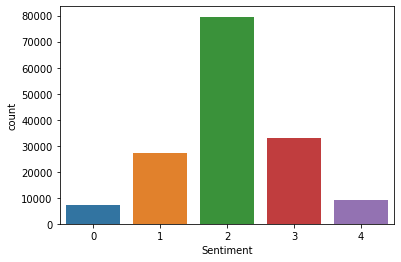

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
import csv
import seaborn as sns
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
import re
from nltk.stem.porter import PorterStemmer
porter_stem = PorterStemmer()
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
import string
from nltk.stem import wordnet
import matplotlib.pyplot as plt
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from collections import Counter
trainURL = "https://raw.githubusercontent.com/cacoderquan/Sentiment-Analysis-on-the-Rotten-Tomatoes-movie-review-dataset/master/train.tsv"
train = pd.read_csv(trainURL, sep = '\t')
sns.countplot(data= train, x='Sentiment')

In [ ]:
train.head(10)

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what...,2
6,7,1,of,2
7,8,1,escapades demonstrating the adage that what is...,2
8,9,1,escapades,2
9,10,1,demonstrating the adage that what is good for ...,2


In [ ]:
from nltk.tokenize import word_tokenize
from nltk import FreqDist
from nltk.stem import SnowballStemmer,WordNetLemmatizer
stemmer=SnowballStemmer('english')
lemma=WordNetLemmatizer()
from string import punctuation
import re


def clean_review(review_col):
    review_corpus=[]
    for i in range(0,len(review_col)):
        review=str(review_col[i])
        review=re.sub(r'\d+','',review)
        review=re.sub(r'[^\w\s]','',review)
        review=re.sub(r'(?:^| )\w(?:$| )', ' ', review).strip()
        review=re.sub(r'\s+', ' ', review)
        review=[lemma.lemmatize(w) for w in word_tokenize(str(review).lower())]
        review=' '.join(review)
        review_corpus.append(review)
    return review_corpus
  
train['clean_review']=clean_review(train.Phrase.values)
train.head(10)

,PhraseId,SentenceId,Phrase,Sentiment,clean_review
0,1,1,A series of escapades demonstrating the adage ...,1,series of escapade demonstrating the adage tha...
1,2,1,A series of escapades demonstrating the adage ...,2,series of escapade demonstrating the adage tha...
2,3,1,A series,2,series
3,4,1,A,2,
4,5,1,series,2,series
5,6,1,of escapades demonstrating the adage that what...,2,of escapade demonstrating the adage that what ...
6,7,1,of,2,of
7,8,1,escapades demonstrating the adage that what is...,2,escapade demonstrating the adage that what is ...
8,9,1,escapades,2,escapade
9,10,1,demonstrating the adage that what is good for ...,2,demonstrating the adage that what is good for ...


In [ ]:
from sklearn.utils import resample
train_2 = train[train['Sentiment']==2]
train_1 = train[train['Sentiment']==1]
train_3 = train[train['Sentiment']==3]
train_4 = train[train['Sentiment']==4]
train_5 = train[train['Sentiment']==0]
#train_2_sample = resample(train_2,replace=True,n_samples=79000,random_state=4)
train_1_sample = resample(train_1,replace=True,n_samples=79000,random_state=4)
train_3_sample = resample(train_3,replace=True,n_samples=79000,random_state=4)
train_4_sample = resample(train_4,replace=True,n_samples=79000,random_state=4)
train_5_sample = resample(train_5,replace=True,n_samples=79000,random_state=4)

df_upsampled = pd.concat([train_1_sample, train_2,train_3_sample,train_4_sample,train_5_sample])
#df_upsampled = train
df_upsampled = df_upsampled.loc[df_upsampled.groupby('SentenceId')['PhraseId'].idxmin()]



#group test data
train = train.loc[train.groupby('SentenceId')['PhraseId'].idxmin()]



#Change sentiment to increase readability
df_upsampled['sentiment_label'] = ''
Sentiment_Label = ['Negative', 'Somewhat Negative', 
                  'Neutral', 'Somewhat Positive', 'Positive']
for sent, label in enumerate(Sentiment_Label):
    df_upsampled.loc[df_upsampled.Sentiment == sent, 'sentiment_label'] = label
    
df_upsampled.head()

,PhraseId,SentenceId,Phrase,Sentiment,clean_review,sentiment_label
0,1,1,A series of escapades demonstrating the adage ...,1,series of escapade demonstrating the adage tha...,Somewhat Negative
63,64,2,"This quiet , introspective and entertaining in...",4,this quiet introspective and entertaining inde...,Positive
63,64,2,"This quiet , introspective and entertaining in...",4,this quiet introspective and entertaining inde...,Positive
63,64,2,"This quiet , introspective and entertaining in...",4,this quiet introspective and entertaining inde...,Positive
63,64,2,"This quiet , introspective and entertaining in...",4,this quiet introspective and entertaining inde...,Positive


In [ ]:
print(df_upsampled)


        PhraseId  ...    sentiment_label
0              1  ...  Somewhat Negative
63            64  ...           Positive
63            64  ...           Positive
63            64  ...           Positive
63            64  ...           Positive
...          ...  ...                ...
156021    156022  ...  Somewhat Negative
156021    156022  ...  Somewhat Negative
156031    156032  ...  Somewhat Negative
156031    156032  ...  Somewhat Negative
156039    156040  ...            Neutral

[37652 rows x 6 columns]


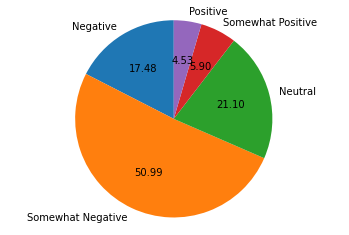

In [ ]:
#Visualizing unbalanced data

import matplotlib.pyplot as plotter
pieLabels  = 'Negative', 'Somewhat Negative', 'Neutral', 'Somewhat Positive', 'Positive'
dataShare     = [len(train_1),len(train_2),len(train_3),len(train_4),len(train_5)]
figureObject, axesObject = plotter.subplots()
axesObject.pie(dataShare,
        labels=pieLabels,
        autopct='%1.2f',
        startangle=90)
axesObject.axis('equal')
plotter.show()

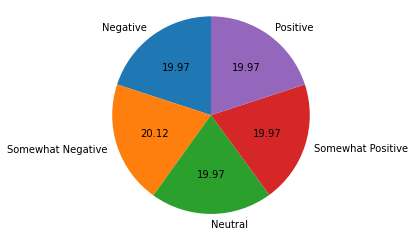

In [ ]:
#visualizing balanced data

import matplotlib.pyplot as plotter
pieLabels  = 'Negative', 'Somewhat Negative', 'Neutral', 'Somewhat Positive', 'Positive'
dataShare     = [len(train_1_sample),len(train_2),len(train_3_sample),len(train_4_sample),len(train_5_sample)]
figureObject, axesObject = plotter.subplots()
axesObject.pie(dataShare,
        labels=pieLabels,
        autopct='%1.2f',
        startangle=90)
axesObject.axis('equal')
plotter.show()

In [ ]:
stopw = list(ENGLISH_STOP_WORDS)

#Create tfidf vectorizer object & fit to full sentence training data
tfidf_vectorizor = TfidfVectorizer(min_df=5, 
                             max_df=0.5,
                             analyzer='word',
                             strip_accents='unicode',
                             ngram_range=(1, 3),
                             sublinear_tf=True, 
                             smooth_idf=True,
                             use_idf=True,
                             norm='l2',
                             stop_words=stopw)



phrase = df_upsampled['clean_review']
sentiment = df_upsampled['Sentiment']
tfidf_vectorizor.fit(list(df_upsampled['clean_review']))


TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.5, max_features=None,
                min_df=5, ngram_range=(1, 3), norm='l2', preprocessor=None,
                smooth_idf=True,
                stop_words=['thereupon', 'co', 'hereafter', 'beside', 'move',
                            'must', 'perhaps', 'upon', 'until', 'never', 'you',
                            'someone', 'both', 'where', 'very', 'somewhere',
                            'whom', 'around', 'if', 'afterwards', 'at',
                            'within', 'everywhere', 'were', 'latter',
                            'otherwise', 'hence', 'several', 'over', 'us', ...],
                strip_accents='unicode', sublinear_tf=True,
                token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
                vocabulary=None)

In [ ]:
# Helper functions to create graphics below from tf-idf matrices
#adapted from : https://buhrmann.github.io/tfidf-analysis.html
def top_tfidf_feats(row, features, top_n=5):
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_feats_in_doc(Xtr, features, row_id, top_n=5):
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=5):
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

def top_feats_by_class(Xtr, y, features, min_tfidf=0.1, top_n=5):
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

def plot_tfidf_classfeats_h(dfs, num_class=9):
    fig = plt.figure(figsize=(12, 100), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(num_class, 1, i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.set_ylabel("Word", labelpad=16, fontsize=16)
        ax.set_title(str(df.label) + ' Sentiment Class', fontsize=25, color='blue')
        ax.barh(x, df.tfidf, align='center')
        ax.set_yticks(x)
        ax.invert_yaxis()
        yticks = ax.set_yticklabels(df.feature)
        
        for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(20) 
        plt.subplots_adjust(bottom=0.001, right=0.5, left=0.15, top=0.25, wspace=0.2)
    plt.show()
    
phrase.shape, sentiment.shape

((37652,), (37652,))

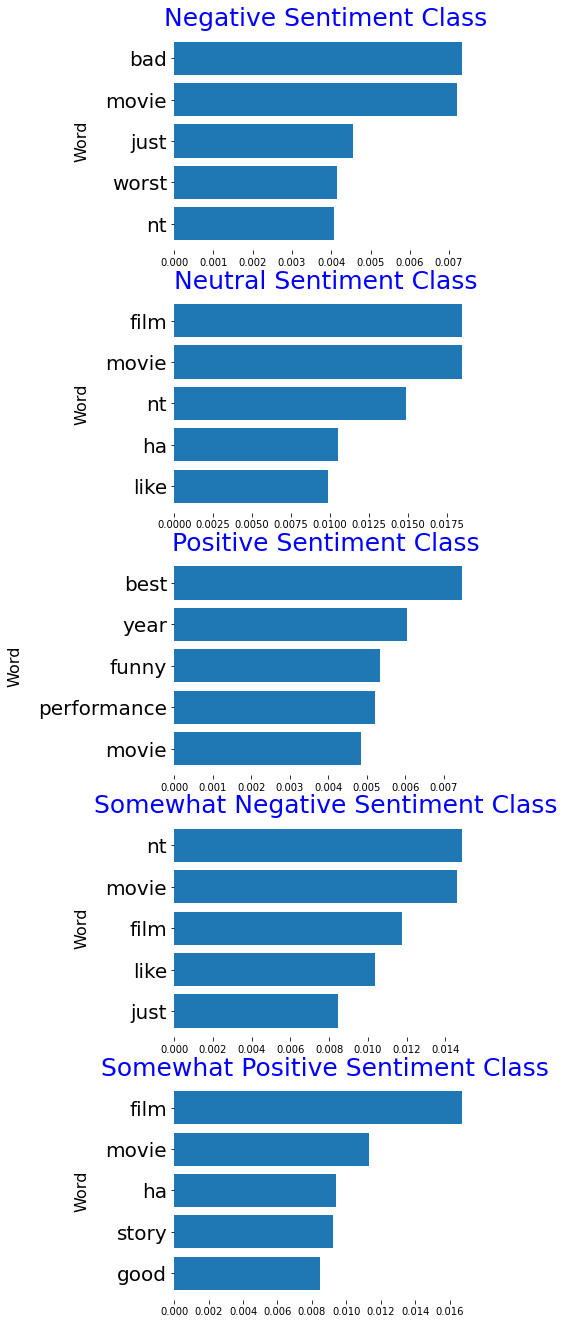

In [ ]:
# Visualize vocabulary
class_Xtr = tfidf_vectorizor.transform(phrase)
class_y = df_upsampled['sentiment_label']
class_features = tfidf_vectorizor.get_feature_names()
class_top_dfs = top_feats_by_class(class_Xtr, class_y, class_features)
plot_tfidf_classfeats_h(class_top_dfs, 7)

In [ ]:
#len(class_features)



In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(phrase, 
                                                    sentiment, 
                                                    test_size=0.2, 
                                                    random_state=4)


#TRAIN TEST SPLIT - ORIGINAL DATA

OX_train, OX_test, OY_train, OY_test = train_test_split(train['clean_review'],train['Sentiment'], test_size=0.2, random_state=4)


In [ ]:
#printing upsampled
print("Balanced Shapes")
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape



Balanced Shapes


((30121,), (30121,), (7531,), (7531,))

In [ ]:
#print(Y_train)

In [ ]:
#print(Y_train)

In [ ]:
#printing original samples shapes
print("Original Samples Shapes")
OX_train.shape, OY_train.shape, OX_test.shape, OY_test.shape

Original Samples Shapes


((6823,), (6823,), (1706,), (1706,))

In [ ]:
train_tfidf = tfidf_vectorizor.transform(X_train)
test_tfidf = tfidf_vectorizor.transform(X_test)
#print(train_tfidf.shape)
tfidf_feature_vec = pd.DataFrame(test_tfidf.toarray(), columns=tfidf_vectorizor.get_feature_names())
#tfidf_feature_vec.head(8)



#from imblearn.over_sampling import SMOTE
#sm = SMOTE(random_state = 4)

#X_train_new, y_train_new = sm.fit_sample(train_tfidf, Y_train.ravel())
#pd.Series(y_train_new).value_counts().plot.bar()

In [ ]:
train_tfidf_mat = train_tfidf.toarray()
print(type(train_tfidf_mat),train_tfidf_mat.shape)

<class 'numpy.ndarray'> (30121, 49923)


In [ ]:
Y_train.shape
Y_train[0:10]

105940    1
97657     0
65378     0
12490     1
13397     0
135436    1
112637    0
8744      0
83624     3
145928    4
Name: Sentiment, dtype: int64

In [ ]:
from keras.utils import to_categorical
# one hot encode
Y_train = to_categorical(Y_train)
Y_train.shape
Y_train[0:10,]

Using TensorFlow backend.


array([[0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [ ]:
from keras import backend as K
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, Flatten 
from keras.layers import Activation, Conv1D, GlobalMaxPooling1D
from keras import optimizers

# CNN Model
def baseline_cnn_model(fea_matrix, n_class, compiler):
    # model
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', 
                   input_shape=(fea_matrix.shape[1],fea_matrix.shape[2])))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Dropout(0.2))
    model.add(Activation('relu'))
    model.add(Dense(64))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Activation('relu'))
    model.add(Dense(n_class))
    model.add(Activation('softmax'))
    model.summary()  
    # compile
    model.compile(optimizer=compiler, loss='categorical_crossentropy', 
                  metrics=['acc',f1_m,precision_m, recall_m])
    return model



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 49921, 32)         128       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 24960, 32)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 24958, 64)         6208      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 12479, 64)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12479, 64)         0         
_________________________________________________________________
activation_1 (Activation)    (None, 12479, 64)         0         
_________________________________________________________________
dense_1 (Dense)              (None, 12479, 64)        

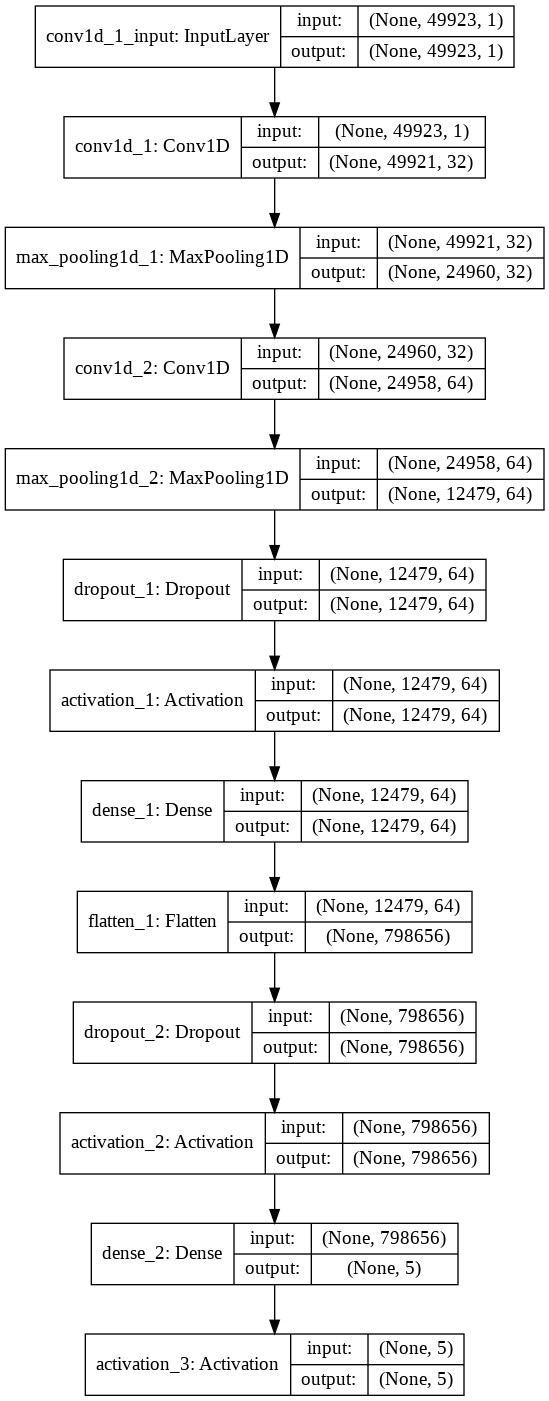

In [ ]:
fea_vec_dim = train_tfidf_mat.shape[1]
n_class = 5
X_train = train_tfidf_mat.reshape((train_tfidf_mat.shape[0], train_tfidf_mat.shape[1], 1))
lr = 1e-3
batch_size = 128
num_epochs = 50
decay=1e-4
Nadam = optimizers.Nadam(lr = lr , beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay = 0.0004)#, schedule_decay=0.0004)
model = baseline_cnn_model(X_train, n_class, Nadam)

from keras.utils.vis_utils import plot_model  
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True) 
from IPython.display import Image
Image(retina=True, filename='model_plot.png')

In [ ]:
import timeit
start = timeit.default_timer()
history = model.fit(X_train, Y_train, batch_size=batch_size,epochs=num_epochs,verbose=1,validation_split=0.2)
stop = timeit.default_timer()
print('Training Time : ', stop - start)

Train on 24096 samples, validate on 6025 samples
Epoch 1/50
24096/24096 [==============================] - 50s 2ms/step - loss: 0.7322 - acc: 0.7293 - f1_m: 0.6488 - precision_m: 0.7475 - recall_m: 0.6060 - val_loss: 0.3628 - val_acc: 0.8830 - val_f1_m: 0.8891 - val_precision_m: 0.9106 - val_recall_m: 0.8688
Epoch 2/50
24096/24096 [==============================] - 43s 2ms/step - loss: 0.1640 - acc: 0.9463 - f1_m: 0.9469 - precision_m: 0.9548 - recall_m: 0.9392 - val_loss: 0.3150 - val_acc: 0.9210 - val_f1_m: 0.9234 - val_precision_m: 0.9300 - val_recall_m: 0.9170
Epoch 3/50
24096/24096 [==============================] - 43s 2ms/step - loss: 0.0757 - acc: 0.9765 - f1_m: 0.9764 - precision_m: 0.9786 - recall_m: 0.9742 - val_loss: 0.3413 - val_acc: 0.9230 - val_f1_m: 0.9259 - val_precision_m: 0.9302 - val_recall_m: 0.9217
Epoch 4/50
24096/24096 [==============================] - 43s 2ms/step - loss: 0.0413 - acc: 0.9873 - f1_m: 0.9875 - precision_m: 0.9884 - recall_m: 0.9866 - val_loss: 

In [ ]:
model.save_weights('mcsa-new.h5')
model.save('anuj.h5')
# test_tfidf
test_tfidf_mat = test_tfidf.toarray()

# reshape from [samples, sequence] into [samples, sequence, features]
fea_vec_dim = test_tfidf_mat.shape[1]
n_class = 5
X_test = test_tfidf_mat.reshape((test_tfidf_mat.shape[0], test_tfidf_mat.shape[1], 1))
X_test.shape
Y_test = to_categorical(Y_test)
Y_test.shape
# evaluate
def print_metrics(accuracy, f1_score, precision, recall, start, stop):  
    print('CNN MODEL PERFORMANCE')
    print('Accuracy:', np.round(accuracy, 4))
    print('Precision:', np.round(precision, 4))
    print('Recall:', np.round(recall, 4))
    print('F1 Score:', np.round(f1_score, 4))
    print('Total Training Time:', stop-start)
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, Y_test, verbose=0)
print_metrics(accuracy, f1_score, precision, recall, start, stop)

CNN MODEL PERFORMANCE
Accuracy: 0.926
Precision: 0.9306
Recall: 0.9247
F1 Score: 0.9276
Total Training Time: 2148.362477502


In [ ]:
from google.colab import drive
drive.mount('/content/ddrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/ddrive


In [ ]:
modelname = 'mcsa.h5'
path = "D/content/gdrive/My Drive/{modelname}"
model.save_weights('mcsa.h5',path)
model.save('anuj.h5')

In [ ]:
testtext = [' One of the best movies I have ever seen.']
testtext = clean_review(testtext)
testtf = tfidf_vectorizor.transform(testtext)
testtf1 = testtf.toarray()
prediction = testtf1.reshape((testtf1.shape[0], testtf1.shape[1], 1))

rr = model.predict(prediction)[0]

if(np.argmax(rr) == 0):
   print("Negative")
elif (np.argmax(rr) == 1):
   print("Somewhat Negative")
elif (np.argmax(rr) == 2):
   print("Neutral")
elif (np.argmax(rr) == 3):
  print("Somewhat Positive")
elif (np.argmax(rr) == 4):
  print("Positive")    


Positive


dict_keys(['val_loss', 'val_acc', 'val_f1_m', 'val_precision_m', 'val_recall_m', 'loss', 'acc', 'f1_m', 'precision_m', 'recall_m'])


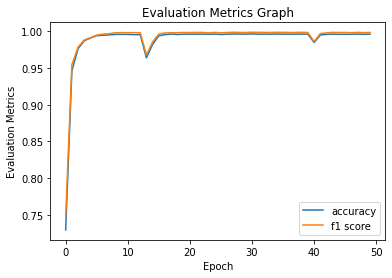

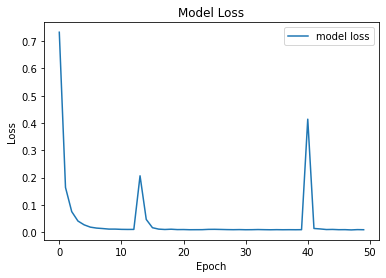

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['precision_m'])


plt.title('Evaluation Metrics Graph')
plt.ylabel('Evaluation Metrics')
plt.xlabel('Epoch')
plt.legend(['accuracy', 'f1 score', 'precision', 'recall'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['model loss'], loc='upper right')
plt.show()